# Spesifikasi

- V<sub>in</sub> = 48V
- V<sub>out</sub> = 12V
- P<sub>o</sub> = 100W
- &#916;V<sub>o</sub> &#8804; 1%
- &#916;I<sub>L</sub> &#8804; 10%
- f<sub>sw</sub> = 20e3
- Mosfet: IRFB4310PbF, Infineon

# Plecs

In [2]:
import xmlrpc.client as xml
import os
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import csv

In [9]:
model = 'buck_1'
file_type = '.plecs'
V_in = 48
V_out = 12

In [10]:
plecs = xml.Server("http://localhost:1080/RPC2").plecs

In [11]:
plecs.load(r"E:\OneDrive - UGM 365\Mata Kuliah\Skripsi\Plecs\Python\buck\buck_1.plecs")


0

# Parameter

L<sub>min</sub> &lt; 144&mu;H &lt; 509&mu;H &lt; 1003&mu;H &lt; L<sub>max</sub>



L<sub>min</sub> 30&mu;H; L<sub>max</sub>2000&mu;H

C<sub>min</sub> 20&mu;F; C<sub>max</sub>1000&mu;F

f<sub>min</sub> 20kHz; f<sub>max</sub>200kHz

diambil 20 x 20 x 20

di mana f itu continous dan L, C diskret

<strong>Parameter yang berubah</strong>:
- f
- L
- C
- R<sub>L</sub> = 
- ESL
- ESR = 

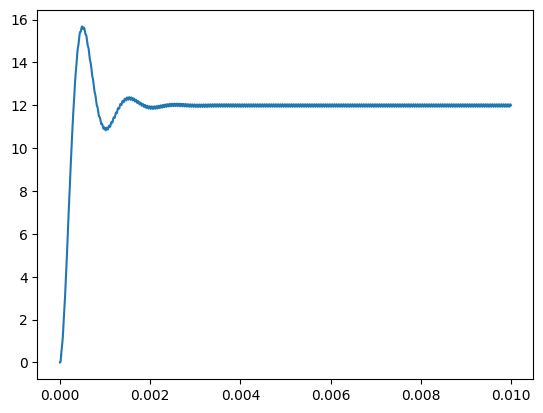

In [16]:
L = 540e-6
C = 43.38e-6
fsw = 20e3

plecs.set(model+'/L1','L', str(L))
plecs.set(model+'/C', 'C', str(C))
plecs.set(model+'/Symmetrical PWM1', 'fc', str(fsw))
times = plecs.simulate(model) ['Time']
current = plecs.simulate(model) ['Values'][0]
voltage = plecs.simulate(model) ['Values'][1]

plt.plot(times,voltage)

# Try add output (losses into CSV)

In [38]:
L_range = (30e-6, 2000e-6)  # Range for L
C_range = (30e-6, 200e-6)   # Range for C
fsw_range = (20e3, 200e3)    # Range for fsw
num_values = 2           # Number of values for each parameter

# Borders for R_L
border_values = [
    (144e-6, 0.079576),
    (509e-6, 0.179228),
    (1003e-6, 0.253239),
    (2519e-6, 0.443394)
]

# Constants for ESL calculation
K_esl = 4.389e-11  # Adjust as needed
tan_delta = 0.14

# Create arrays of discrete L, C, and fsw values within the specified ranges
L_values = np.linspace(L_range[0], L_range[1], num=num_values)
C_values = np.linspace(C_range[0], C_range[1], num=num_values)
fsw_values = np.linspace(fsw_range[0], fsw_range[1], num=num_values)

# Initialize arrays to store results
average_currents = []
delta_currents = []
delta_currents_percentage = []

# Open a CSV file for writing
csv_file_path = 'simulation_results.csv'

# Define the header for the CSV file
csv_header = ['No','L', 'C', 'fsw', 'RL', 'ESR', 'ESL', 'delta_current_percentage', 'delta_voltage_percentage']

# Initialize a list to store the data for each simulation
csv_data = []

# Print the chosen values
print("Chosen L values:", L_values)
print("Chosen C values:", C_values)
print("Chosen fsw values:", fsw_values)

# Generate all combinations of L, C, and fsw
combinations = list(itertools.product(L_values, C_values, fsw_values))

# Display the chosen values and simulate
print("\nChosen values and simulation results:")

Chosen L values: [3.e-05 2.e-03]
Chosen C values: [3.e-05 2.e-04]
Chosen fsw values: [ 20000. 200000.]

Chosen values and simulation results:


### CSV

In [33]:
def write_to_csv(file_path, header, data):
    with open(file_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(header)
        csv_writer.writerows(data)
    data = []

### Average Current and &Delta;I<sub>L</sub>%

In [26]:
def calculate_current(times, current, start_time, end_time):
    # Convert 'times' to a NumPy array
    times = np.array(times)

    # Find the indices corresponding to the time range
    start_index = np.argmax(times >= start_time)
    end_index = np.argmax(times >= end_time)

    # Extract the current values in the specified time range
    current_range = current[start_index:end_index]

    # Calculate the average current value
    average_current = np.mean(current_range)

    # Calculate the difference between the highest and lowest current values
    delta_current = np.max(current_range) - np.min(current_range) 

    print('Current:')
    print("\nmax:", np.max(current_range))
    print("\nmin:", np.min(current_range))
    print("\ndelta:",delta_current)
    print("\naverage:",average_current)

    # print(np.max(current_range))
    # print(np.min(current_range))
    delta_current_percentage = delta_current/average_current * 100

    return average_current, delta_current, delta_current_percentage

### &Delta;V<sub>O</sub>%


In [27]:
def calculate_voltage(times, voltage, start_time, end_time):
    # Convert 'times' to a NumPy array
    times = np.array(times)

    # Find the indices corresponding to the time range
    start_index = np.argmax(times >= start_time)
    end_index = np.argmax(times >= end_time)

    # Extract the voltage values in the specified time range
    voltage_range = voltage[start_index:end_index]

    # Calculate the average voltage value
    average_voltage = np.mean(voltage_range)

    # Calculate the difference between the highest and lowest voltage values
    delta_voltage = np.max(voltage_range) - np.min(voltage_range)

    print('Voltage:')
    print("\nmax:", np.max(voltage_range))
    print("\nmin:", np.min(voltage_range))
    print("\ndelta:",delta_voltage)
    print("\naverage:",average_voltage)

    delta_voltage_percentage = delta_voltage/average_voltage * 100

    return average_voltage, delta_voltage, delta_voltage_percentage


### Loop

In [43]:
# Loop through the combinations and simulate
csv_data = []
for simulation_num, (L, C, fsw) in enumerate(combinations, start=1):
    # Rules for picking R_L based on L
    R_L = next((rl for border, rl in border_values if L <= border), 0.0)

    # Calculate ESR and ESL based on the updated C
    ESR = tan_delta / (2 * np.pi * fsw * C)
    ESL = K_esl / C

    # Set Plecs parameters and simulate
    plecs.set(model+'/L1', 'L', str(L))
    plecs.set(model+'/C', 'C', str(C))
    plecs.set(model+'/Symmetrical PWM1', 'fc', str(fsw))
    plecs.set(model+'/RL', 'R', str(R_L))
    plecs.set(model+'/ESR', 'R', str(ESR))
    plecs.set(model+'/ESL', 'L', str(ESL))

    times = plecs.simulate(model)['Time']
    current = plecs.simulate(model)['Values'][0]
    voltage = plecs.simulate(model)['Values'][1]

    # Calculate average and delta current using the function
    average_current, delta_current, delta_current_percentage = calculate_current(times, current, start_time=0.004, end_time=0.005)
    average_voltage, delta_voltage, delta_voltage_percentage = calculate_voltage(times, voltage, start_time=0.004, end_time=0.005)

    # Append the data for this simulation to the list
    csv_data.append([simulation_num,L, C, fsw, R_L, ESR, ESL, average_current, delta_current_percentage, delta_voltage_percentage])

    print(f'\nSimulation {simulation_num} for L={L:.6f}, C={C:.6f}, fsw={fsw:.2f}, RL={R_L:.6f}, ESR={ESR:.6f}, ESL={ESL:.6e}')
    print(f"\nSimulation {simulation_num} results:")
    print(f"Average Current between 0.004 and 0.005 seconds: {average_current} A")
    print(f"Difference between highest and lowest current values between 0.004 and 0.005 seconds: {delta_current} A")
    print(f"Difference between highest and lowest current values between 0.004 and 0.005 seconds: {delta_current_percentage} %")
    print(f"Difference between highest and lowest voltage values between 0.004 and 0.005 seconds: {delta_voltage} A")
    print(f"Difference between highest and lowest voltage values between 0.004 and 0.005 seconds: {delta_voltage_percentage} %")

Current:

max: 9.962085899925917

min: -4.982265328516976

delta: 14.944351228442894

average: 3.2556026550071735
Voltage:

max: 12.675008038889622

min: 10.055806220980628

delta: 2.619201817908994

average: 11.548067497351191

Simulation 1 for L=0.000030, C=0.000030, fsw=20000.00, RL=0.079576, ESR=0.037136, ESL=1.463000e-06

Simulation 1 results:
Average Current between 0.004 and 0.005 seconds: 3.2556026550071735 A
Difference between highest and lowest current values between 0.004 and 0.005 seconds: 14.944351228442894 A
Difference between highest and lowest current values between 0.004 and 0.005 seconds: 459.0348642657058 %
Difference between highest and lowest voltage values between 0.004 and 0.005 seconds: 2.619201817908994 A
Difference between highest and lowest voltage values between 0.004 and 0.005 seconds: 22.680866894047572 %
Current:

max: 3.0936817782626678

min: 1.6425465629588225

delta: 1.4511352153038453

average: 2.4480963015005166
Voltage:

max: 13.445362653254902

min

In [44]:
# Use the function to write data to the CSV file
write_to_csv(csv_file_path, csv_header, csv_data)

In [18]:
print("\nOverall Results:")
print("Average Currents:", average_currents)
print("Delta Currents:", delta_currents)


Overall Results:
Average Currents: [3.2556026550071735, 2.4480963015005166, 2.259277826903446, 2.4145527294792837, 2.2077869921943662, 2.2057074895283653, 2.179446821143291, 2.1830247327071093]
Delta Currents: [14.944351228442894, 1.4511352153038453, 15.007081334424608, 1.52246913350394, 0.22498826109326675, 0.02249104753892084, 0.5629873617854202, 0.3716887031785807]


### Switching Losses

#### Conduction Loss

- R<sub>DS(on)</sub> = R<sub>ON-H</sub> = R<sub>ON-L</sub> = 5.6k&Omega; 

##### High Side

P<sub>ON-H</sub> = I<sub>OUT</sub> / 2 &times; R<sub>ON-H</sub> &times; V<sub>OUT</sub> / V<sub>IN</sub> [W]


In [ ]:
R_on = 5.6

P_ON_H = average_current / 2 * R_on * V_out / V_in

##### Low Side

P<sub>ON-L</sub> = I<sub>OUT</sub> / 2 &times; R<sub>ON-L</sub> &times; (1 - V<sub>OUT</sub> / V<sub>IN</sub>) [W]


In [ ]:
P_ON_L = average_current / 2 * R_on * V_out / V_in

#### Switching Losses

- t<sub>rise</sub> = 110 ns  
- t<sub>fall</sub> = 78 ns

##### High Side

P<sub>SW-H</sub> = 1/2 &times; V<sub>IN</sub> &times; I<sub>OUT</sub> &times; (t<sub>rise-H</sub> + t<sub>fall-H</sub>) &times; f<sub>SW</sub>


In [ ]:
t_rise = 110e-9
t_fall = 78e-9

P_SW_H = 0.5 * V_in * average_current * (t_rise + t_fall) * f_sw

##### Low Side

P<sub>SW-L</sub> = 1/2 &times; V<sub>D</sub> &times; I<sub>OUT</sub> &times; (t<sub>rise-L</sub> + t<sub>fall-L</sub>) &times; f<sub>SW</sub>


In [ ]:
P_SW_L = 0.5 * V_in * average_current * (t_rise + t_fall) * f_sw

#### Losses Total

In [ ]:
Switching_loss = P_ON_H + P_ON_L + P_SW_H + P_SW_L

### Capacitor Loss

P<sub>CAP(ESR)</sub> = I<sub>CAP(RMS)</sub><sup>2</sup>  &#x00D7; ESR [W]



ESR = tan(&#x03B4;) / 2&pi;f<sub>SW</sub>C)

Dengan 25 V Nippon KZE series: tan &#x03B4; = 0.14

In [ ]:
ESR = 0.14 / (2*np.pi*f_sw*C)
print(ESR)

ESL = 1 / (4π² SRF² C)
- Assume SRF = 100kHz

In [ ]:
SRF  = 100e3
ESL = 1 / (4*np.pi**2*SRF**2*C)

print(ESL)

#### Input Capacitor

I<sub>CIN(RMS)</sub> = I<sub>OUT</sub> &times; &radic;(V<sub>IN</sub> - V<sub>OUT</sub>) &times; V<sub>OUT</sub> / V<sub>IN</sub> [A]


In [ ]:
I_cin = average_current * np.sqrt(V_in - V_out) * V_out / V_in

#### Output Capacitor

I<sub>COUT(RMS)</sub> = &Delta;I<sub>L</sub> / (2&radic;3) [A]

&Delta;I<sub>L</sub> = (V<sub>IN</sub> - V<sub>OUT</sub>) / (f<sub>SW</sub> &times; L) &times; V<sub>OUT</sub> / V<sub>IN</sub> [A]


In [ ]:
I_L = ((V_in - V_out) / (f_sw * L)) * (V_out/V_in)
print(I_L)

In [ ]:
I_cout = I_L / (2*np.sqrt(3))
print(I_cout)

#### Total Loss

In [ ]:
P_cap_in = I_cin**2 * ESR
P_cap_out = I_cout**2 * ESR

Capacitor_losses = P_cap_in + P_cap_out

### Inductor Loss

#### Inductor Copper Loss

P<sub>Copper, L</sub> = I<sub>RMS</sub><sup>2</sup> &middot; R<sub>L</sub>
<br>
I<sub>RMS</sub> = &radic;(I<sub>AVG</sub><sup>2</sup> + <sup>1</sup>&frasl;<sub>12</sub> &Delta;I<sub>L</sub><sup>2</sup>)



In [ ]:
I_rms = np.sqrt(average_current**2 + 1/12 * delta_current**2)
print(I_rms)

In [ ]:
P_copper = I_rms**2 * float(R_L)
print(P_copper)

### Ripples

#### &Delta;I<sub>L</sub>%


## Loop and save into CSV